In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
#define DFT transformation function
def DFT1D(img):
    U = len(img)
    outarry = np.zeros(U, dtype=complex)
    for m in range(U):
        sum = 0.0
        for n in range(U):
            e = np.exp(-1j * 2 * np.pi * m * n / U)
            sum += img[n] * e
        outarry[m] = sum
    return outarry

In [3]:
def IDFT1D(img):
    U = len(img)
    outarry = np.zeros(U,dtype=complex)
    for n in range(U):
        sum = 0.0
        for m in range(U):
            e = np.exp(1j * 2 * np.pi * m * n / U)
            sum += img[m]*e
        pixel = sum/U
        outarry[n]=pixel
    return outarry

In [4]:
# Define Gaussian Low pass filter
def GaussianLP(D0,U,V):
    H = np.zeros((U, V))
    D = np.zeros((U, V))
    U0 = int(U / 2)
    V0 = int(V / 2)
    # calculate distance
    for u in range(U):
        for v in range(V):
            u2 = np.power(u, 2)
            v2 = np.power(v, 2)
            D[u, v] = np.sqrt(u2 + v2)
    # calculate filter
    for u in range(U):
        for v in range(V):
            H[u, v] = np.exp((-D[np.abs(u - U0), np.abs(v - V0)]**2)/(2*(D0**2)))
    return H

In [5]:
# Define butterworth low pass filter
def butterworthLP(D0,U,V,n):
    H = np.zeros((U, V))
    D = np.zeros((U, V))
    U0 = int(U / 2)
    V0 = int(V / 2)
    # calculate distance
    for u in range(U):
        for v in range(V):
            u2 = np.power(u, 2)
            v2 = np.power(v, 2)
            D[u, v] = np.sqrt(u2 + v2)
    #calculate filter
    for u in range(U):
        for v in range(V):
            H[u, v] = 1/((1+ D[np.abs(u - U0), np.abs(v - V0)]/D0)**(2*n))
    return H

In [6]:
# Define Ideals low pass function
def lowPass_Ideals(D0,U,V):
    H = np.zeros((U, V))
    D = np.zeros((U, V))
    U0 = int(U / 2)
    V0 = int(V / 2)
    # calculate distance
    for u in range(U):
        for v in range(V):
            u2 = np.power(u, 2)
            v2 = np.power(v, 2)
            D[u, v] = np.sqrt( u2 +v2)
    # calculate filter
    for u in range(U):
        for v in range(V):
            if D[np.abs(u - U0), np.abs(v - V0)] <= D0:
                H[u, v] = 1
            else:
                H[u, v] = 0
    return H

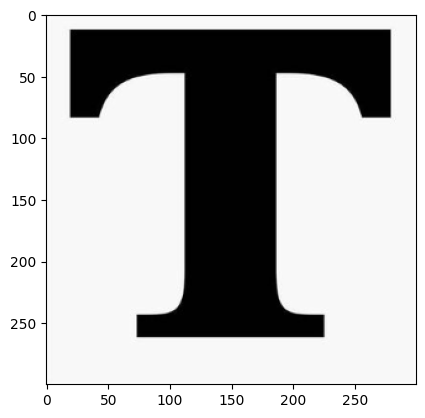

In [7]:
#read image
image = cv2.imread("face picture.jpg", 0)
image = cv2.resize( src=image, dsize=(300, 300))

f = np.asarray(image)
M, N = np.shape(f)
plt.imshow(image,cmap='gray')

In [8]:
# Step 1: Convert image from MxN size to PxQ image with P= 2M and Q = 2N
P, Q = 2*M , 2*N
shape = np.shape(f)
# Convert the PxQ image to the f_xy_p array
f_xy_p = np.zeros((P, Q))
f_xy_p[:shape[0], :shape[1]] = f

# Step 2: Multiply the image fp(x,y) with (-1) exponent (x+y) to create a new image
     # The result of multiplication is saved to the image matrix fpc
F_xy_p = np.zeros((P, Q))
for x in range(P):
  for y in range(Q):
    F_xy_p[x, y] = f_xy_p[x, y] * np.power(-1, x + y)

# Step 3: Convert Fpc image to frequency domain (DFT)
dft_cols = np.zeros((P, Q))
dft_rows = np.zeros((P, Q))

# DFT by P - column
for i in range(P):
    dft_cols[i] = DFT1D(F_xy_p[i])

# DFT by Q - row
for j in range(Q):
    dft_rows[:, j] = DFT1D(dft_cols[:, j])

C:\Users\nguye\AppData\Local\Temp\ipykernel_232\3934939491.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
  dft_cols[i] = DFT1D(F_xy_p[i])
C:\Users\nguye\AppData\Local\Temp\ipykernel_232\3934939491.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  dft_rows[:, j] = DFT1D(dft_cols[:, j])


In [9]:
# Step 4: Perform Gaussian Low Pass Filtering
G_uv = np.multiply(dft_rows, GaussianLP(30,P,Q))

# Step 6:
# Step 6.1 Perform the DFT inverse transform
idft_cols = idft_rows = np.zeros((P, Q))

# # Inverse DFT conversion in P - cols
for i in range(P):
    idft_cols[i] = IDFT1D(G_uv[i])

# Inverse DFT conversion in Q - rows
for j in range(Q):
    idft_rows[:, j] = IDFT1D(idft_cols[:, j])

C:\Users\nguye\AppData\Local\Temp\ipykernel_232\2005085957.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  idft_cols[i] = IDFT1D(G_uv[i])
C:\Users\nguye\AppData\Local\Temp\ipykernel_232\2005085957.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  idft_rows[:, j] = IDFT1D(idft_cols[:, j])


In [10]:
# Step 6.2: Multiply the real part of the image after inverse transformation by -1 exponent (x+y)
g_array = np.asarray(idft_rows.real)
P, Q = np.shape(g_array)
g_xy_p = np.zeros((P, Q))
for x in range(P):
  for y in range(Q):
      g_xy_p[x, y] = g_array[x, y] * np.power(-1, x + y)

# Step 7: Extract MxN size image from PxQ
# And here is the image after filtering
g_xy = g_xy_p[:shape[0], :shape[1]]

In [11]:
def normalize_image(image):
    min_value = np.min(image)
    max_value = np.max(image)
    normalized_image = (image - min_value) / (max_value - min_value)
    normalized_image = normalized_image * 255
    return normalized_image.astype(np.uint8)

In [12]:
normalized_g_xy = normalize_image(g_xy)

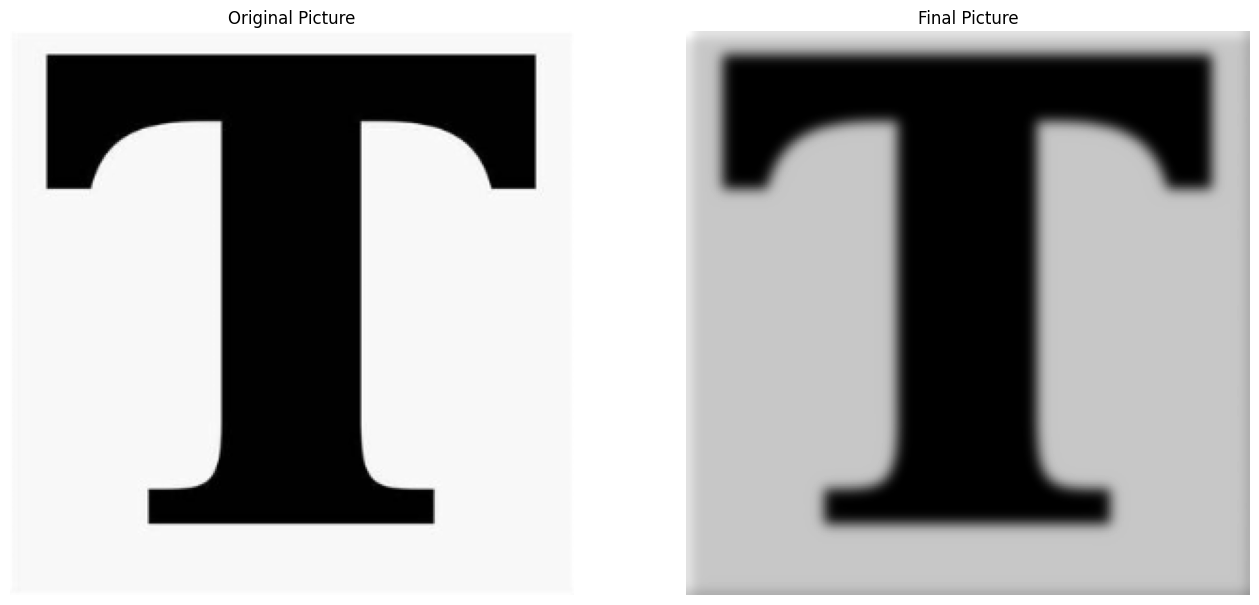

In [13]:
fig = plt.figure(figsize=(16, 9))
ax1, ax9 = fig.subplots(1,2)

# Show the original picture
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Picture')
ax1.axis('off')

# Show the final image
ax9.imshow(normalized_g_xy, cmap='gray')
ax9.set_title('Final Picture')
ax9.axis('off')
plt.show()

In [14]:
# Step 4: Perform Gaussian Low Pass Filtering
G_uv = np.multiply(dft_rows, butterworthLP(30,P,Q,2))

# Step 6:
# Step 6.1 Perform the DFT inverse transform
idft_cols = idft_rows = np.zeros((P, Q))

# # Inverse DFT conversion in P - cols
for i in range(P):
    idft_cols[i] = IDFT1D(G_uv[i])

# Inverse DFT conversion in Q - rows
for j in range(Q):
    idft_rows[:, j] = IDFT1D(idft_cols[:, j])

# Step 6.2: Multiply the real part of the image after inverse transformation by -1 exponent (x+y)
g_array = np.asarray(idft_rows.real)
P, Q = np.shape(g_array)
g_xy_p = np.zeros((P, Q))
for x in range(P):
  for y in range(Q):
      g_xy_p[x, y] = g_array[x, y] * np.power(-1, x + y)

# Step 7: Extract MxN size image from PxQ
# And here is the image after filtering
g_xy = g_xy_p[:shape[0], :shape[1]]

C:\Users\nguye\AppData\Local\Temp\ipykernel_232\2644041335.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  idft_cols[i] = IDFT1D(G_uv[i])
C:\Users\nguye\AppData\Local\Temp\ipykernel_232\2644041335.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  idft_rows[:, j] = IDFT1D(idft_cols[:, j])


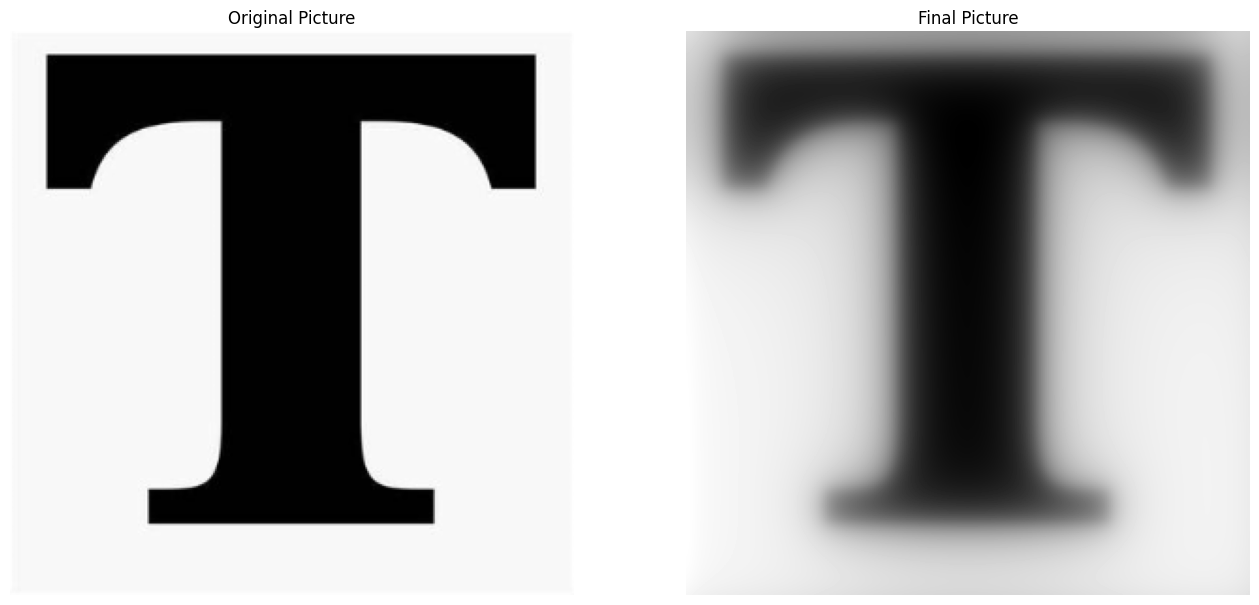

In [15]:
fig = plt.figure(figsize=(16, 9))
ax1, ax9 = fig.subplots(1,2)

# Show the original picture
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Picture')
ax1.axis('off')

# Show the final image
ax9.imshow(g_xy, cmap='gray')
ax9.set_title('Final Picture')
ax9.axis('off')
plt.show()